In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import datetime

from numpy import random

from ipywidgets import *
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)

## Data Processing

In [ ]:
# ed_df = pd.read_csv('ED Admit-Discharge Data - 2020-08.csv', 
#                  parse_dates=['ED Arrival Date/Time', 'Dispo Order D/T', 'Bed Assign', 'EP Assess','Checkout D/T', 
#                               'Discharge D/T', 'Full Reg', 'Full Reg2'])

# ed_df = ed_df[ed_df['Financial Number'].notna()]
# ed_df.drop(labels=['day of week', 'Column1', 'Unnamed: 26','Unnamed: 27'], inplace=True, axis=1)
# ed_df['Tracking Group'] = 'CSM-M'
# ed_df['Arrival Mode'].fillna(value='Unknown', inplace=True)
# ed_df['Arrival Mode'].replace({' ': 'Unknown'}, inplace=True)
# ed_df['Acuity'].replace({' ': -1}, inplace=True)
# ed_df['Acuity'].fillna(value= 0, inplace=True)                    
# ed_df['Acuity'] = ed_df['Acuity'].astype('int')
# # ed_df['LOS Checkout'] = ed_df['Checkout D/T'] - ed_df.index
# ed_df['LOS Checkout'] = ed_df['Checkout D/T'] - ed_df['ED Arrival Date/Time']
# ed_df['LOS Depart'].replace(to_replace='#MULTIVALUE', value=np.NAN, inplace=True)

# ed_df.to_pickle("ed_data")

In [2]:
ed_df = pd.read_pickle('ed_data')

In [4]:
# hos_df = pd.read_csv('Hospital Sheet.csv', engine='python',
#                     parse_dates=['Arrival Date & Time', 'Discharge Order D/T', 'Discharge Date & Time', 'Documented DC D/T'])

# hos_df.drop(labels=['Day of week', 'Arrival Time of Day .1', 'Unnamed: 23',
#        'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27',  'LOS M:ss2', 'before 9'], axis=1, inplace=True)

# hos_df = hos_df[hos_df['Financial Number'].notna()]

# hos_df.to_pickle("hos_data")

In [5]:
hos_df = pd.read_pickle('hos_data')

In [ ]:
## Merging

# full_df = pd.merge(hos_df, ed_df, on='Financial Number', how='left')

# full_df[full_df['ED FIN?'] == 'YES']['Dispo Order'].unique()

# full_df[(full_df['ED FIN?'] == 'YES') & (full_df['Dispo Order'] == 'ED Discharge Patient')]

In [ ]:
def df_analysis(df):
    
    for col in df.columns:
        uniq = df[col].nunique()
        col_type = df[col].dtype.name

        print(f'Column name: {col}')
        print(f'Number of unique values: {uniq}')
        print(f'Data type: {col_type}')
        
        if col_type != 'datetime64[ns]':
            mode = df[col].mode()
            if mode.tolist():
                print(f'Most frequent value: {mode[0]}')
        
        if uniq < 16.0: 
            print(f'Values: {df[col].unique()}')
            
        if col_type == 'datetime64[ns]':
            print(f'Start date: {df[col].min()}')
            print(f'End date: {df[col].max()}')
        
            
        print()

Plot #1: Histogram of ED Admits by hour

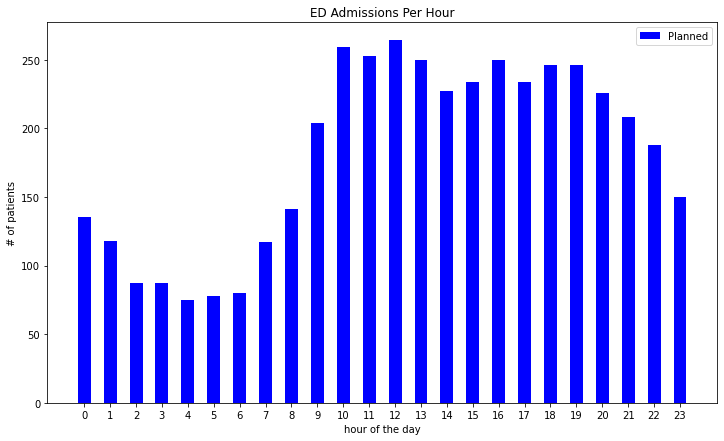

In [6]:
width = 0.5
ind =  np.arange(ed_df['ED Arrival Date/Time'].dt.hour.nunique())
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(ind, ed_df['Financial Number'].groupby( [ed_df['ED Arrival Date/Time'].dt.hour]).count(), width, label='Planned', color='b')

ax.set_ylabel('# of patients')
ax.set_xlabel('hour of the day')
ax.set_title('ED Admissions Per Hour')
ax.set_xticks(ind)
ax.set_xticklabels(np.unique(ed_df['ED Arrival Date/Time'].dt.hour))
# fig.autofmt_xdate()
ax.legend()

plt.show()

Plot #2: Histogram of ED Admits by Day

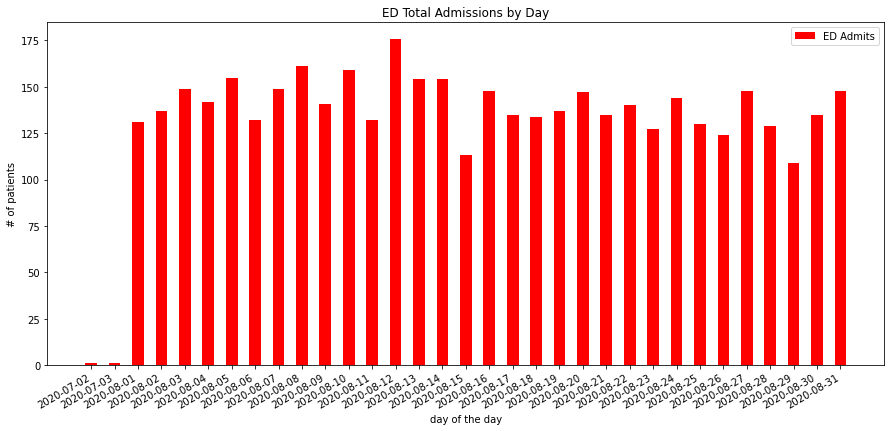

In [7]:
width = 0.5
ind =  np.arange(ed_df['ED Arrival Date/Time'].dt.date.nunique())
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(ind, ed_df['Financial Number'].groupby([ed_df['ED Arrival Date/Time'].dt.date]).count(), width, label='ED Admits', color='r')

ax.set_ylabel('# of patients')
ax.set_xlabel('day of the day')
ax.set_title('ED Total Admissions by Day')
ax.set_xticks(ind)
ax.set_xticklabels(np.unique(ed_df['ED Arrival Date/Time'].dt.date))
fig.autofmt_xdate()
ax.legend()

plt.show()

In [ ]:

def plot_adms(df):
    df = df[(df['Datetime'] > pd.Timestamp(start.value))]
    ind = np.arange(df['Datetime'].dt.day.nunique())
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 7))
    rects1 = ax.bar(ind - width/2, df['Planned'].resample(
        'D').sum().tolist(), width, label='Planned', color='b')
    rects2 = ax.bar(ind + width/2, df['Unplanned'].resample(
        'D').sum().tolist(), width, label='Unplanned', color='r')

    ax.set_ylabel('# of patients')
    ax.set_title('Admissions Per Day')
    ax.set_xticks(ind)
    ax.set_xticklabels(np.unique(df['Datetime'].dt.date))
    fig.autofmt_xdate()
    ax.legend()

    autolabel(ax, rects1, "left")
    autolabel(ax, rects2, "right")

    plt.show()


In [ ]:
# ed_df['ED Dispo'].unique()

In [ ]:
# ed_df['Dispo Order'].unique()

In [ ]:
# ed = ed_df[(ed_df['Dispo Order'] == 'ED Request for Admission') | (ed_df['Dispo Order'] == 'ED Observation')]

__Column ID:__

- Financial Number: per visit unique code
- Tracking Group: particular hospital in group
- Arrival Mode: nan as "Unknown"
- Acuity: ESI level 1 (higher complexity, billing, resources) - 5 (lower)
- ED Dispo: 
- Discharge Dx (Diagnosis)
- Dispo Order: 
- Dispo Order D/T: wrote order to discharge
- Checkout D/T: 
- Bed Assign: admissions time bed assigned
- EP Assess: 


- Patients: 
    - who arrived from ED? 
- Encounter Type: 
    - type of bed
    - Telemetry: general medical w/ continuous cardiac monitoring
    
    
__Modeling__

1. Model the Bed Availability:
- When are patients arriving and what is the avg LOS?

    Factors:
    - ER admissions per hour
    - Non-ER admissions per hour
    - Typical admission LOS by Attending Type & Encounter Type